# Adversarial Robustness of MLP, ViT and CNN on CIFAR-10 and CIFAR-100

### Imports

In [12]:
import time
import detectors

import torch
import timm
from tqdm import tqdm
from torchvision import transforms

from data_utils.data_stats import *
from data_utils.dataloader import get_loader
from models.networks import get_model
from utils.metrics import topk_acc, AverageMeter

### Fetching data loader and model architecture

In [10]:
def get_data_and_model(dataset, model, data_path='/scratch/ffcv/'):
    """
    This function retrieves the data, model and feature extractor (if needed) based on the provided information.

    Parameters:
    dataset (str): The name of the dataset to retrieve (can be cifar10, cifar100 or imagenet).
    model (str): The name of the model to retrieve (can be mlp, cnn or vit; only mlp is supported for dataset imagenet).
    data_path (str): The path to the data.

    Returns (as a tuple):
    data_loader (DataLoader): The retrieved data loader.
    model (Model): The retrieved model.

    Raises:
    AssertionError: If the dataset or model is not supported.
    """

    assert dataset in ('cifar10', 'cifar100', 'imagenet'), f'dataset {dataset} is currently not supported by this function'
    assert model in ('mlp', 'cnn', 'vit'), f'model {model} is currently not supported by this function'

    num_classes = CLASS_DICT[dataset]
    eval_batch_size = 1024
 
    if dataset == 'imagenet':
        data_resolution = 64
        assert model == 'mlp', f'imagenet dataset is only supported by mlp model'
    else:
        data_resolution = 32

    crop_resolution = data_resolution

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device == 'cuda':
        torch.backends.cuda.matmul.allow_tf32 = True

    if model == 'mlp':
        architecture = 'B_12-Wi_1024'
        checkpoint = 'in21k_' + dataset
        model = get_model(architecture=architecture, resolution=64, num_classes=num_classes, checkpoint=checkpoint)

    if model == 'cnn':
        architecture = 'resnet18_' + dataset
        model = timm.create_model(architecture, pretrained=True)

    if model == 'vit':
        architecture = 'vit_small_patch16_224_' + dataset + '_v7.pth'
        model = torch.load(architecture)

    data_loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

    return data_loader, model

In [3]:
class Reshape(torch.nn.Module): 
    def __init__(self, shape=224): 
        super(Reshape, self).__init__()
        self.shape = shape 
        
    def forward(self, x): 
        shape = self.shape
        x = transforms.functional.resize(x, size=(shape, shape))
        if shape == 64:
            bs = x.shape[0]
            x = torch.reshape(x, shape=(bs,-1,))
        return x

### Evaluating baseline model accuracy

In [4]:
# Define a test function that evaluates test accuracy
@torch.no_grad()
def test(model, loader, model_name=None):
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    all_conf, true_label_conv, true_label_corr_conf = [], [], []
    if model_name == 'mlp':
        model = torch.nn.Sequential(Reshape(64), model)
    if model_name == 'vit':
        model = torch.nn.Sequential(Reshape(224), model)

    model.eval()

    for ims, targs in tqdm(loader, desc="Evaluation"):
        preds = model(ims)
        p = torch.nn.functional.softmax(preds, dim = 1)
        all_conf.append(p.flatten().cpu().numpy())
        correct_class_confidences = p[range(ims.shape[0]), targs]
        true_label_conv.append(correct_class_confidences.flatten().cpu().numpy())
        pred_labels = preds.argmax(dim=1)
        correct_mask = pred_labels == targs
        correct_confidences = correct_class_confidences[correct_mask]
        true_label_corr_conf.append(correct_confidences.flatten().cpu().numpy())
        acc, top5 = topk_acc(preds, targs, k=5, avg=True)
        total_acc.update(acc, ims.shape[0])
        total_top5.update(top5, ims.shape[0])

    return (
        total_acc.get_avg(percentage=True),
        total_top5.get_avg(percentage=True),
        all_conf,
        true_label_conv,
        true_label_corr_conf,
    )

In [13]:
dataset_name = 'cifar10'
model_name = 'mlp'

data_loader, model = get_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')
test_acc, test_top5, p, tp, tcp = test(model, data_loader, model_name)

# Print all the stats
print("Test Accuracy        ", "{:.4f}".format(test_acc))
print("Top 5 Test Accuracy          ", "{:.4f}".format(test_top5))

Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/data/ffcv/cifar10/val_32.beton


Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]/home/apouget/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluation: 100%|██████████| 10/10 [00:31<00:00,  3.13s/it]

Test Accuracy         94.0900
Top 5 Test Accuracy           99.6000


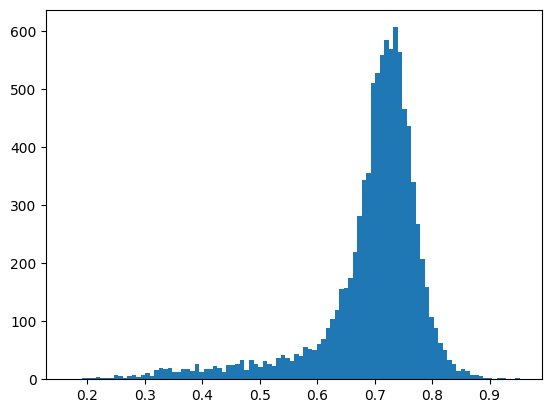

In [23]:
from matplotlib import pyplot as plt

def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

plt.hist(flatten_comprehension(tcp), bins=100)
plt.show()

In [14]:
dataset_name = 'cifar10'
model_name = 'cnn'

data_loader, model = get_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')
test_acc, test_top5, p2, tp2, tcp2 = test(model, data_loader, model_name)

# Print all the stats
print("Test Accuracy        ", "{:.4f}".format(test_acc))
print("Top 5 Test Accuracy          ", "{:.4f}".format(test_top5))

Loading /scratch/data/ffcv/cifar10/val_32.beton


Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <finalize object at 0x7f1789b3d2e0; dead>
Traceback (most recent call last):
  File "/home/apouget/miniconda3/envs/ffcv/lib/python3.9/weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/apouget/miniconda3/envs/ffcv/lib/python3.9/site-packages/numba/core/dispatcher.py", line 312, in finalizer
    for cres in overloads.values():
KeyError: (Array(uint8, 1, 'C', True, aligned=True), Array(uint8, 1, 'C', True, aligned=True), uint32, uint32, uint32, uint32, Literal[int](0), Literal[int](0), Literal[int](1), Literal[int](1), Literal[bool](False), Literal[bool](False))
Exception ignored in: <finalize object at 0x7f17480c0080; dead>
Traceback (most recent call last):
  File "/home/apouget/miniconda3/envs/ffcv/lib/python3.9/weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/apouget/miniconda3/envs/ffcv/lib/python3.9/sit

Test Accuracy         94.4600
Top 5 Test Accuracy           99.8300


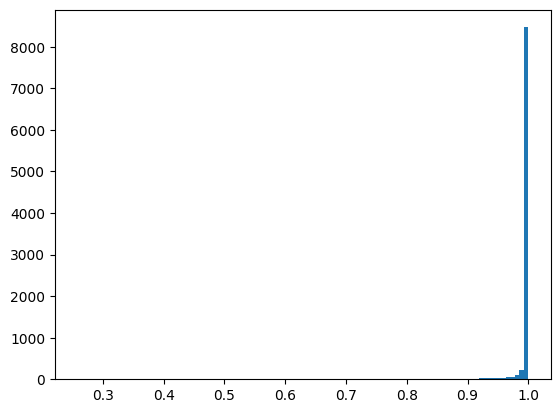

In [27]:
from matplotlib import pyplot as plt

def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

plt.hist(flatten_comprehension(tcp2), bins=100)
plt.show()

In [11]:
dataset_name = 'cifar10'
model_name = 'vit'

data_loader, _ = get_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')
test_acc, test_top5, p3, tp3, tcp3 = test(model, data_loader, model_name)

# Print all the stats
print("Test Accuracy        ", "{:.4f}".format(test_acc))
print("Top 5 Test Accuracy          ", "{:.4f}".format(test_top5))

Loading /scratch/data/ffcv/cifar10/val_32.beton


Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]/home/apouget/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluation: 100%|██████████| 10/10 [27:55<00:00, 167.57s/it]

Test Accuracy         93.7900
Top 5 Test Accuracy           99.8800


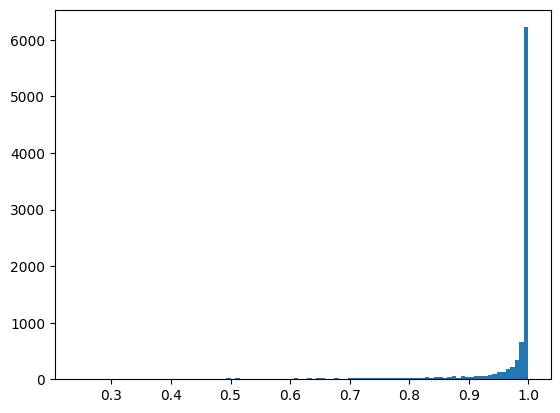

In [15]:
from matplotlib import pyplot as plt

def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

plt.hist(flatten_comprehension(tcp3), bins=100)
plt.show()

In [23]:
'''
This file contains method for generating calibration related plots, eg. reliability plots.

References:
[1] C. Guo, G. Pleiss, Y. Sun, and K. Q. Weinberger. On calibration of modern neural networks.
    arXiv preprint arXiv:1706.04599, 2017.
'''

import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

# Some keys used for the following dictionaries
COUNT = 'count'
CONF = 'conf'
ACC = 'acc'
BIN_ACC = 'bin_acc'
BIN_CONF = 'bin_conf'


def _bin_initializer(bin_dict, num_bins=10):
    for i in range(num_bins):
        bin_dict[i][COUNT] = 0
        bin_dict[i][CONF] = 0
        bin_dict[i][ACC] = 0
        bin_dict[i][BIN_ACC] = 0
        bin_dict[i][BIN_CONF] = 0


def _populate_bins(confs, preds, labels, num_bins=10):
    bin_dict = {}
    for i in range(num_bins):
        bin_dict[i] = {}
    _bin_initializer(bin_dict, num_bins)
    num_test_samples = len(confs)

    for i in range(0, num_test_samples):
        confidence = confs[i]
        prediction = preds[i]
        label = labels[i]
        binn = int(math.ceil(((num_bins * confidence) - 1)))
        bin_dict[binn][COUNT] = bin_dict[binn][COUNT] + 1
        bin_dict[binn][CONF] = bin_dict[binn][CONF] + confidence
        bin_dict[binn][ACC] = bin_dict[binn][ACC] + \
            (1 if (label == prediction) else 0)

    for binn in range(0, num_bins):
        if (bin_dict[binn][COUNT] == 0):
            bin_dict[binn][BIN_ACC] = 0
            bin_dict[binn][BIN_CONF] = 0
        else:
            bin_dict[binn][BIN_ACC] = float(
                bin_dict[binn][ACC]) / bin_dict[binn][COUNT]
            bin_dict[binn][BIN_CONF] = bin_dict[binn][CONF] / \
                float(bin_dict[binn][COUNT])
    return bin_dict


def reliability_plot(confs, preds, labels, num_bins=15):
    '''
    Method to draw a reliability plot from a model's predictions and confidences.
    '''
    bin_dict = _populate_bins(confs, preds, labels, num_bins)
    bns = [(i / float(num_bins)) for i in range(num_bins)]
    y = []
    for i in range(num_bins):
        y.append(bin_dict[i][BIN_ACC])
    plt.figure(figsize=(10, 8))  # width:20, height:3
    plt.bar(bns, bns, align='edge', width=0.05, color='pink', label='Expected')
    plt.bar(bns, y, align='edge', width=0.05,
            color='blue', alpha=0.5, label='Actual')
    plt.ylabel('Accuracy')
    plt.xlabel('Confidence')
    plt.legend()
    plt.show()


def bin_strength_plot(confs, preds, labels, num_bins=15):
    '''
    Method to draw a plot for the number of samples in each confidence bin.
    '''
    bin_dict = _populate_bins(confs, preds, labels, num_bins)
    bns = [(i / float(num_bins)) for i in range(num_bins)]
    num_samples = len(labels)
    y = []
    for i in range(num_bins):
        n = (bin_dict[i][COUNT] / float(num_samples)) * 100
        y.append(n)
    plt.figure(figsize=(10, 8))  # width:20, height:3
    plt.bar(bns, y, align='edge', width=0.05,
            color='blue', alpha=0.5, label='Percentage samples')
    plt.ylabel('Percentage of samples')
    plt.xlabel('Confidence')
    plt.show()

100% |########################################################################|


Load_state output <All keys matched successfully>
Loading /scratch/data/ffcv/cifar100/test_32.beton


Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]/home/apouget/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluation: 100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


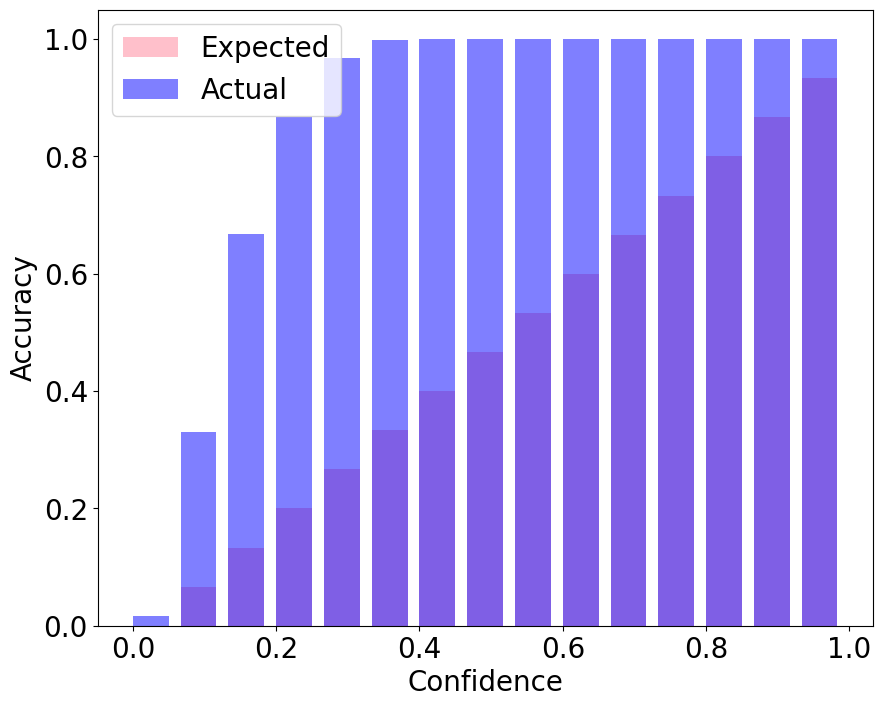

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

dataset_name = 'cifar100'
model_name = 'mlp'

dataloader, model = get_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')
model = torch.nn.Sequential(Reshape(64), model)

def reliability_diagram(model, dataloader):
    model.eval()
    conf = torch.tensor([])
    pred = torch.tensor([])
    targ = torch.tensor([])

    with torch.no_grad():
        for ims, targs in tqdm(dataloader, desc="Evaluation"):
            preds = model(ims)
            p = torch.nn.functional.softmax(preds, dim = 1)
            correct_class_confidences = p[range(ims.shape[0]), targs]
            pred_labels = preds.argmax(dim=1)
            conf = torch.cat((conf, correct_class_confidences))
            pred = torch.cat((pred, pred_labels))
            targ = torch.cat((targ, targs))

    reliability_plot(conf, pred, targ)

reliability_diagram(model, dataloader)


Loading /scratch/data/ffcv/cifar100/test_32.beton


Evaluation: 100%|██████████| 10/10 [02:50<00:00, 17.10s/it]


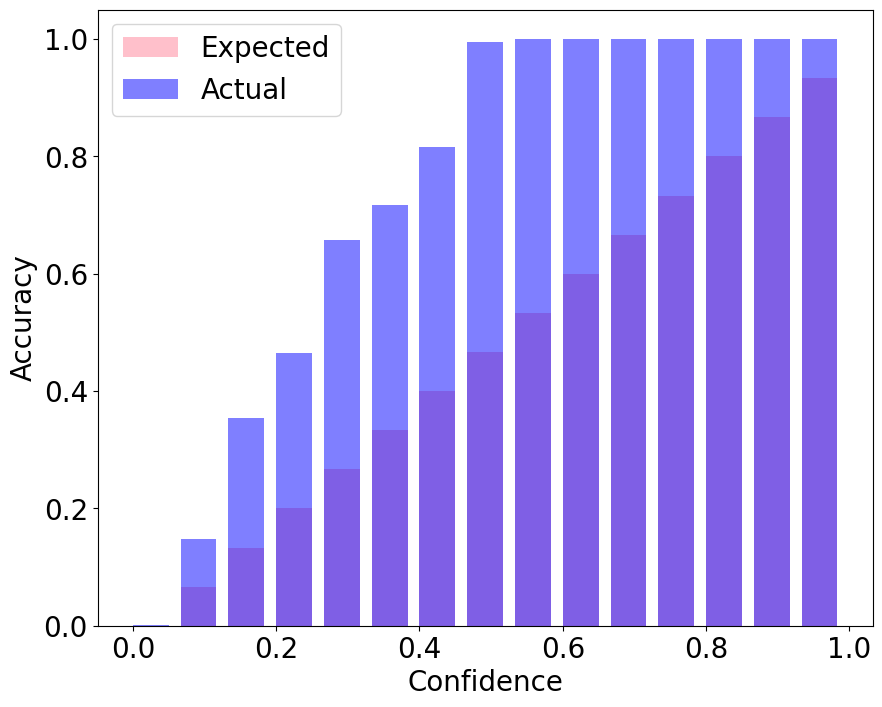

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

dataset_name = 'cifar100'
model_name = 'cnn'

dataloader, model = get_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')

def reliability_diagram(model, dataloader):
    model.eval()
    conf = torch.tensor([])
    pred = torch.tensor([])
    targ = torch.tensor([])

    with torch.no_grad():
        for ims, targs in tqdm(dataloader, desc="Evaluation"):
            preds = model(ims)
            p = torch.nn.functional.softmax(preds, dim = 1)
            correct_class_confidences = p[range(ims.shape[0]), targs]
            pred_labels = preds.argmax(dim=1)
            conf = torch.cat((conf, correct_class_confidences))
            pred = torch.cat((pred, pred_labels))
            targ = torch.cat((targ, targs))

    reliability_plot(conf, pred, targ)



reliability_diagram(model, dataloader)


### Evaluate inference time vs accuracy

In [ ]:
# Define a test function that evaluates inference time
@torch.no_grad()
def get_inference_time(model, loader, model_name=None):
    if model_name == 'mlp':
        model = torch.nn.Sequential(Reshape(64), model)
    if model_name == 'vit':
        model = torch.nn.Sequential(Reshape(224), model)

    model.eval()

    start = time.time()
    for ims, _ in loader:
        _ = model(ims)
    end = time.time()

    return end-start

In [ ]:
dataset_name = 'cifar10'
model_name = 'mlp'

data_loader, model = get_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')
print(f"Inference time for {model_name} on {dataset_name}: {get_inference_time(model, data_loader, model_name):.4f}")